In [359]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

           binary_node_df_full: 12.5 GiB
   imputed_binary_node_df_full: 12.5 GiB
                      SCMatrix:  7.0 GiB
                   post_adata2:  3.5 GiB
                     matrix_df:  3.5 GiB
                       Z_score:  3.5 GiB
         SCMatrix_preprocessed:  1.1 GiB
                       info_df: 17.3 MiB
                          _227: 17.3 MiB
                    post_adata: 12.7 MiB


In [358]:
del dist
del _247

In [1]:
from scvi.dataset import CsvDataset
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import CortexDataset, RetinaDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer
import pickle
import scanpy as sc
import anndata
import torch

[2020-01-14 14:38:02,372] INFO - scvi._settings | Added StreamHandler with custom formatter to 'scvi' logger.
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/sklearn/utils/linear_assignment_.py:22: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


In [ ]:
save_path = '/bigstore/binfo/mouse/Hippocampus/'
local_csv_dataset = CsvDataset(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.csv.gz'),
                               save_path=save_path,
                               sep=' ',
                               batch_ids_file=os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.batch_ids.csv'),
                               compression='gzip')

In [ ]:
use_batches = True
test_mode = True
# Train the model and output model likelihood every 5 epochs
vae = VAE(local_csv_dataset.nb_genes, n_batch=local_csv_dataset.n_batches * use_batches)
trainer = UnsupervisedTrainer(
    vae, 
    local_csv_dataset, 
    train_size=0.9 if not test_mode else 0.5, 
    use_cuda=True,
    frequency=5,
)
trainer.train(n_epochs=50, lr=1e-3)

In [ ]:
full = trainer.create_posterior(trainer.model, local_csv_dataset, indices=np.arange(len(local_csv_dataset)))
print("Entropy of batch mixing :", full.entropy_batch_mixing())

In [ ]:
latent, batch_indices, labels = full.sequential().get_latent()
imputed_values = full.sequential().imputation()
normalized_values = full.sequential().get_sample_scale()

In [2]:
save_path = '/bigstore/binfo/mouse/Hippocampus/'
raw_values = pd.read_csv(os.path.join(save_path,'TBI.SHAM.countdata.with.celltypes.csv.gz'),sep=' ')
raw_values.head()

,S1Hip_CCTTGCCACACT_ODC,S1Hip_TTCTATTCGTAG_ODC,S1Hip_TTGGGCCCACCG_ODC,S1Hip_ATGTACGCCGTG_ODC,S1Hip_CCAGAATAATTT_ODC,S1Hip_CCGCTCAAGTCC_ODC,S1Hip_GGAGGATTGGGT_ODC,S1Hip_AGTCACTGTTTA_ODC,S1Hip_TAAAACCTATCG_ODC,S1Hip_CCGTCCCGAGTT_ODC,...,TBI5Hip_TCCTGAGACGCT_EPEN,TBI5Hip_TTGCGCAAAACG_EPEN,TBI5Hip_ACGCCGAGTTGC_EPEN,TBI5Hip_CAGCATATGGCG_EPEN,TBI5Hip_GACATCATTCAT_EPEN,TBI5Hip_GGTATTGACACC_EPEN,TBI5Hip_TCCCACGCCAAC_EPEN,TBI5Hip_TTCCTGTAGACC_EPEN,TBI5Hip_ATTTAATTGAGC_EPEN,TBI5Hip_ATCCCTCGCAGC_EPEN
Reps1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Soga3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Rps15,2,1,1,1,0,0,0,1,0,0,...,0,1,0,0,0,0,1,0,1,0
Anks1b,1,0,0,2,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
Eea1,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,1,0,0,0


In [ ]:
# Plotting the likelihood change across the 50 epochs of training: 
# blue for training error and orange for testing error. 
%matplotlib inline
elbo_train = trainer.history["elbo_train_set"]
elbo_test = trainer.history["elbo_test_set"]
x = np.linspace(0, 50, (len(elbo_train)))
plt.plot(x, elbo_train)
plt.plot(x, elbo_test)
plt.ylim(min(elbo_train)-50, 3500)

In [2]:
import pickle
matrix = pickle.load(open('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.normalized.pkl','rb'))
latent = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.latent.csv.gz',index_col=0)
genes = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.genes.csv',index_col=0)
info_df = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.info_df.csv',index_col=0)


In [200]:
matrix.shape

(29013, 32355)

In [201]:
Z_score = (matrix-np.average(matrix,axis=0))/np.std(matrix,axis=0)
Z_score.shape

(29013, 32355)

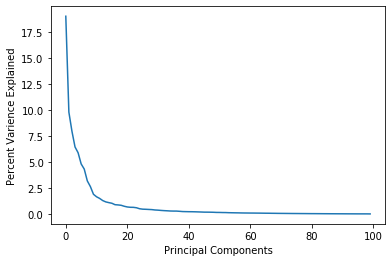

In [202]:
%matplotlib inline
import pickle
ndim = 100
post_adata2 = anndata.AnnData(X=Z_score)
sc.tl.pca(post_adata2,n_comps=ndim)
x = range(ndim)
y = 100*post_adata2.uns['pca']['variance_ratio']
plt.plot(x,y)
plt.xlabel('Principal Components')
plt.ylabel('Percent Varience Explained')
plt.show()

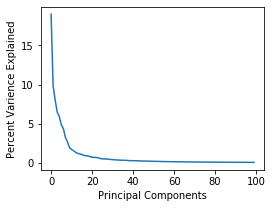

In [204]:
plt.figure(figsize=[4,3])
plt.plot(x,y)
plt.xlabel('Principal Components')
plt.ylabel('Percent Varience Explained')
plt.show()

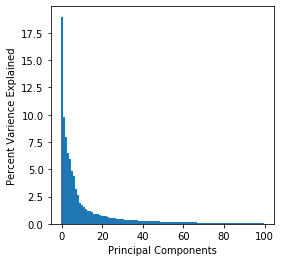

In [209]:
plt.figure(figsize=[4,4])
plt.bar(x,y,width=1)
plt.xlabel('Principal Components')
plt.ylabel('Percent Varience Explained')
plt.show()

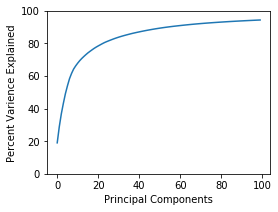

In [327]:
plt.figure(figsize=[4,3])
x = range(ndim)
y = 100*post_adata2.uns['pca']['variance_ratio']
plt.plot(x,np.cumsum(y))
plt.xlabel('Principal Components')
plt.ylabel('Percent Varience Explained')
plt.ylim([0,100])
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F2_scRNAseq_PCA_analysis.pdf')
# plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F2_scRNAseq_PCA_analysis.svg', format='svg')
plt.show()

In [ ]:
%matplotlib inline
ndim = 30
post_adata = anndata.AnnData(X=local_csv_dataset.X)
sc.tl.pca(post_adata,n_comps=ndim)
x = range(ndim)
y = 100*post_adata.uns['pca']['variance_ratio']
plt.plot(x,y)
plt.xlabel('Principal Components')
plt.ylabel('Percent Varience Explained')
plt.show()

In [ ]:
%matplotlib inline
import pickle

ndim = 30
normalized_values = 
post_adata2 = anndata.AnnData(X=normalized_values)
sc.tl.pca(post_adata2,n_comps=ndim)
x = range(ndim)
y = 100*post_adata2.uns['pca']['variance_ratio']
plt.plot(x,y)
plt.xlabel('Principal Components')
plt.ylabel('Percent Varience Explained')
plt.show()

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs

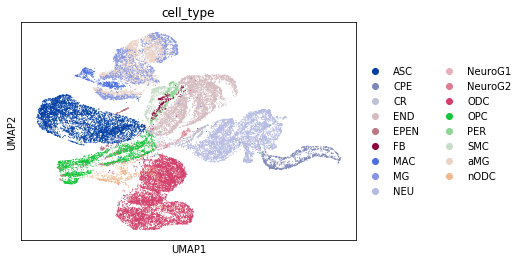

In [216]:
post_adata = anndata.AnnData(X=matrix)
post_adata.obsm["matrix"] = matrix
post_adata.obsm["X_scVI"] = np.array(latent)
post_adata.obs['cell_type'] = np.array(info_df['cell_type'])
post_adata.obs['label'] = np.array(range(len(info_df)))
post_adata.obs['cell'] = pd.Series(info_df.index, dtype="category")
post_adata.obs['region'] = np.array(info_df['region'])
post_adata.obs['dataset'] = np.array(info_df['dataset'])
post_adata.obs['treatment'] = np.array(info_df['treatment'])
sc.pp.neighbors(post_adata)
sc.tl.umap(post_adata)
sc.pl.umap(post_adata, color='cell_type')

In [224]:
sc.settings.figdir = '/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/'

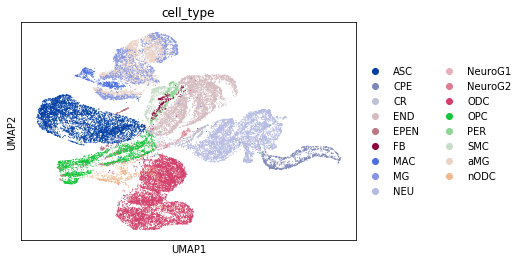

In [225]:
sc.pl.umap(post_adata, color='cell_type',save='F5a_scRNAseq_UMAP.pdf')

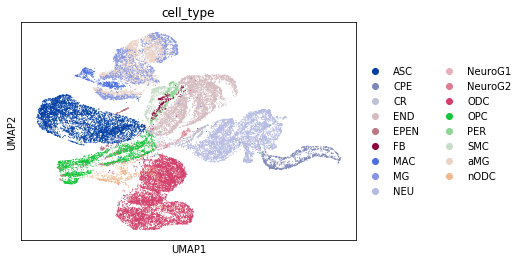

In [328]:
sc.pl.umap(post_adata, color='cell_type',save='F5a_scRNAseq_UMAP.pdf')

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs

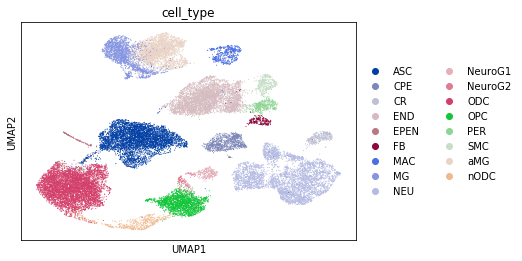

In [19]:
post_adata2 = anndata.AnnData(X=latent)
post_adata2.obsm["matrix"] = matrix
post_adata2.obsm["X_scVI"] = np.array(latent)
post_adata2.obs['cell_type'] = np.array(info_df['cell_type'])
post_adata2.obs['label'] = np.array(range(len(info_df)))
post_adata2.obs['cell'] = pd.Series(info_df.index, dtype="category")
post_adata2.obs['region'] = np.array(info_df['region'])
post_adata2.obs['dataset'] = np.array(info_df['dataset'])
post_adata2.obs['treatment'] = np.array(info_df['treatment'])
sc.pp.neighbors(post_adata2)
sc.tl.umap(post_adata2)
sc.pl.umap(post_adata2, color='cell_type')

In [21]:
post_adata2.obs['cell'] = list(info_df.index)
post_adata2.obs['cell'] = post_adata2.obs['cell'].astype('category')
post_adata2.obs

,cell_type,label,cell,region,dataset,treatment
S1Hip_CCTTGCCACACT_ODC,ODC,0,S1Hip_CCTTGCCACACT_ODC,Hip,S1,SHAM
S1Hip_TTCTATTCGTAG_ODC,ODC,1,S1Hip_TTCTATTCGTAG_ODC,Hip,S1,SHAM
S1Hip_TTGGGCCCACCG_ODC,ODC,2,S1Hip_TTGGGCCCACCG_ODC,Hip,S1,SHAM
S1Hip_ATGTACGCCGTG_ODC,ODC,3,S1Hip_ATGTACGCCGTG_ODC,Hip,S1,SHAM
S1Hip_CCAGAATAATTT_ODC,ODC,4,S1Hip_CCAGAATAATTT_ODC,Hip,S1,SHAM
...,...,...,...,...,...,...
TBI5Hip_GGTATTGACACC_EPEN,EPEN,29008,TBI5Hip_GGTATTGACACC_EPEN,Hip,TBI5,TBI
TBI5Hip_TCCCACGCCAAC_EPEN,EPEN,29009,TBI5Hip_TCCCACGCCAAC_EPEN,Hip,TBI5,TBI
TBI5Hip_TTCCTGTAGACC_EPEN,EPEN,29010,TBI5Hip_TTCCTGTAGACC_EPEN,Hip,TBI5,TBI
TBI5Hip_ATTTAATTGAGC_EPEN,EPEN,29011,TBI5Hip_ATTTAATTGAGC_EPEN,Hip,TBI5,TBI


In [22]:
sc.tl.dendrogram(post_adata2, groupby='cell')
sc.pl.dendrogram(post_adata2)

TypeError: dendrogram() missing 1 required positional argument: 'groupby'

In [28]:
post_adata2

AnnData object with n_obs × n_vars = 29013 × 10 
    obs: 'cell_type', 'label', 'cell', 'region', 'dataset', 'treatment'
    uns: 'neighbors', 'cell_type_colors', 'dendrogram_cell', 'dendrogram_cell_type'
    obsm: 'matrix', 'X_scVI', 'X_umap'

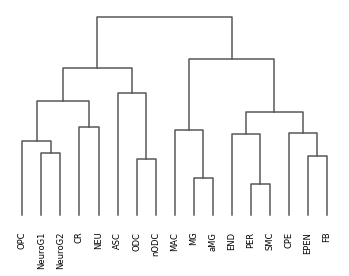

In [24]:
sc.pl.dendrogram(post_adata2, groupby='cell_type')

In [ ]:
sc.pl.dendrogram(post_adata2, groupby='cell')

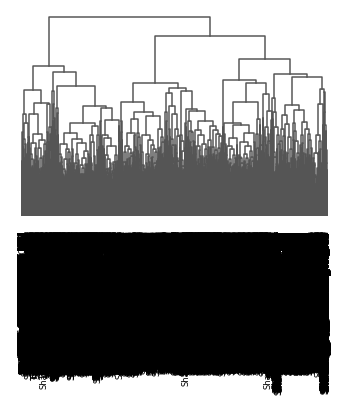

In [30]:
sc.pl.dendrogram(post_adata2, groupby='cell')

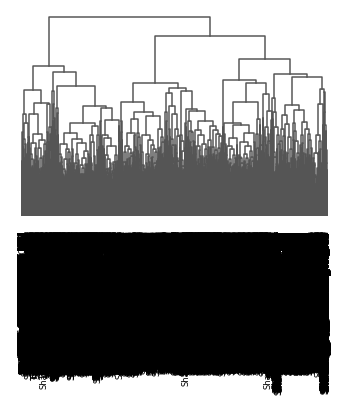

In [31]:
%matplotlib inline
sc.pl.dendrogram(post_adata2, groupby='cell')

In [228]:
class CompressedSensingClass(object):
    def __init__(self,matrix,latent,info_df,
                 metric='cell_type',
                 nblanks=None,
                 npos=50,
                 nbits=18,
                 ncpu=1,
                 pop_ncpu=1,
                 keepers=10,
                 mutation_rate=0.1,
                 offspring_number=0,
                 mutation_number=0,
                 k=100,
                 sample=1000,
                 survivors=[],
                 iterations=100,
                 base_path='',
                 color='r',
                 fresh=True,
                 verbose=True):
        self.metric = metric
        self.info_df = info_df
        self.cell_types = self.info_df.cell_type.unique()
        self.fresh = fresh
        self.verbose = verbose
        if base_path == '':
            base_path = os.path.join(os.getcwd(),'Results')
        self.base_path = base_path
        if not os.path.exists(self.base_path):
            os.mkdir(self.base_path)
        else:
            print('Found Existing Path\n',self.base_path)
            if self.fresh:
                print('base_path already exists and will be overwritten')
                shutil.rmtree(self.base_path)
                os.mkdir(self.base_path)
            else:
                print('loading dict from file isnt supported yet')
        self.cells = list(matrix.columns)
        self.ncells = len(self.cells)
        if nblanks==None:
            nblanks = npos
        blanks = pd.DataFrame(np.zeros((nblanks,self.ncells)),index=['blank'+str(i)for i in range(nblanks)],columns=self.cells)
        self.matrix = pd.concat([matrix,blanks])
        self.gene_variance = np.std(self.matrix ,axis=1)
        self.nblanks = nblanks
        del matrix
        self.genes = list(self.matrix.index)
        self.ngenes = len(self.genes)
        self.npos = npos
        self.nbits = nbits
        self.ncpu = ncpu
        self.pop_ncpu = pop_ncpu
        self.keepers = keepers
        self.ideal = np.zeros(self.ngenes)
        self.ideal[0:npos] = 1
        self.ideal = list(self.ideal)
        self.mutation_rate = mutation_rate
        self.offspring_number = offspring_number
        self.mutation_number = mutation_number
        self.k = k # could infer
        self.sample = sample
        self.survivors = survivors
        self.iterations = iterations
        self.color = color

    def generate_random(self):
        species = np.zeros((self.ngenes,self.nbits))
        for i in range(self.nbits):
            x = random.sample(list(range(self.ngenes)),self.npos)
            species[x,i] = 1
        return species

    def generate_starting_survivors(self):
        survivors = []
        for k in range(self.keepers):
            survivors.append(self.generate_random())
        self.survivors = survivors

    def generate_mutations(self,species):
        mutated = species.copy()
        for y in range(self.nbits):
            for x in random.sample(list(range(self.ngenes)),int(self.mutation_rate*self.ngenes)):
                mutated[x,y] = random.sample(self.ideal,1)[0]
        return mutated

    def generate_offspring(self,species,mate):
        offspring = species.copy()
        for y in range(self.nbits):
            for x in random.sample(list(range(self.ngenes)),int(self.ngenes/2)):
                offspring[x,y] = mate[x,y]
        return offspring

    def generate_progenerators(self):
        progenerators = self.survivors.copy()
        for species in self.survivors:
            for i in range(self.offspring_number):
                mate = self.survivors[random.randint(0,self.keepers-1)].copy()
                progenerators.append(self.generate_offspring(species,mate))
        self.progenerators = progenerators

    def pfunc_generate_mutations(self,species):
        ppopulation = []
        for i in range(self.mutation_number):
            ppopulation.append(self.generate_mutations(species))
        return ppopulation

    def generate_population(self):
        population = self.progenerators.copy()
        if self.mutation_number>0:
            if self.pop_ncpu==1:
                for species in self.progenerators:
                    for i in range(self.mutation_number):
                        population.append(self.generate_mutations(species))
            else:
                sys.stdout.flush()
                with Pool(self.pop_ncpu) as p:
                    for ppopulation in p.imap(self.pfunc_generate_mutations,self.progenerators,chunksize=1):
                        for species in ppopulation:
                            population.append(species)
                sys.stdout.flush()
        self.population = population

    def generate_compressed(self,species):
        compressed = pd.DataFrame(index=self.cells)
        temp_matrix = np.array(self.matrix)
        out = []
        for i in range(self.nbits):
            compressed[i] = np.sum(np.multiply(temp_matrix,species[:,i][...,None]),axis=0)
        return compressed

    def calculate_metric(self,compressed):
        X = np.array(compressed.copy())
        cells = np.array(self.cells)
        n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
        dist = euclidean_distances(X, X[n,:])
        rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
        metrics = []
        correlations = []
        for i,idx in enumerate(n):
            cell = cells[idx]
            knn = cells[rank[:,i]]
            knn = knn[knn!=cell]
            sig = self.matrix[cell]
            avg = np.average(self.matrix[knn[1:]],axis=1)
            correlation = spearmanr(sig,avg)[0]
            if self.metric =='imputation':
                metric = 1-np.nanmean(np.abs((sig-avg)/self.gene_variance))
            elif self.metric == 'cell_type':
                cell = self.info_df.loc[knn[0]].cell_type
                temp_df = self.info_df.loc[knn[1:]]
                metric = len(temp_df[temp_df.cell_type==cell])/self.k
            elif self.metric == 'dendogram':
                print('Not implemented')
#             metric = np.divide(np.sqrt(np.sum(np.square(np.subtract(sig,avg)))),self.nbits)
            correlation = spearmanr(sig,avg)[0]
            metrics.append(metric)
            correlations.append(correlation)
        metric = np.average(metrics)
        correlation = np.average(correlations)
        return metric,correlation

    def pfunc(self,species):
        compressed = self.generate_compressed(species)
        metric,correlation = self.calculate_metric(compressed)
        return species,compressed,metric,correlation
    
    def selection(self):
        new_population = []
        compresseds = []
        metrics = []
        correlations = []
        if self.ncpu==1:
            for species in tqdm.tqdm(self.population):
                species,compressed,metric,correlation = self.pfunc(species)
                new_population.append(species)
                compresseds.append(compressed)
                metrics.append(metric)
                correlations.append(correlation)
        else:
            sys.stdout.flush()
            with Pool(self.ncpu) as p:
                for species,compressed,metric,correlation in tqdm.tqdm(p.imap(self.pfunc,self.population,chunksize=1),total=len(self.population)):
                    new_population.append(species)
                    compresseds.append(compressed)
                    metrics.append(metric)
                    correlations.append(correlation)
            sys.stdout.flush()
        df = pd.DataFrame(index=range(len(self.population)))
        df['population'] = new_population
        df['metrics'] = metrics
        df['compresseds'] = compresseds
        df['correlations'] = correlations
        df = df.sort_values('metrics',ascending=False)
        survivors = df.iloc[:self.keepers]
        self.metrics = list(survivors['metrics'])
        self.compresseds = list(survivors['compresseds'])
        self.correlations = list(survivors['correlations'])
        self.survivors = list(survivors['population'])
        self.elite_survivor = self.survivors[0]
    
    def populate(self):
        self.generate_progenerators()
        self.generate_population()
            
    def evolve(self):
        start_time = time.time()
        self.X = []
        self.Y = []
        self.max = []
        self.min = []
        if len(self.survivors) != self.keepers:
            self.generate_starting_survivors()
        display.clear_output(wait=True)
        for I in range(self.iterations):
            if self.verbose:
                print('Iteration '+str(I))
            self.populate()
            self.selection()
            pickle.dump(self.elite_survivor,open(os.path.join(self.base_path,str('elite_survivor_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.survivors,open(os.path.join(self.base_path,str('survivors_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.metrics,open(os.path.join(self.base_path,str('metrics_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.compresseds,open(os.path.join(self.base_path,str('compresseds_'+str(I)+'.pkl')),'wb'))
            pickle.dump(self.correlations,open(os.path.join(self.base_path,str('correlations_'+str(I)+'.pkl')),'wb'))
            avg = np.average(self.metrics)
            std = np.std(self.metrics) 
            self.X.append((time.time()-start_time)/(60*60))
            self.Y.append(avg)
            self.max.append(avg+std)
            self.min.append(avg-std)
            if self.verbose:
#                 pl.plot(self.X,np.log10(self.Y),c='k',linewidth=1)
#                 pl.fill_between(self.X,np.log10(self.max),np.log10(self.min),color=self.color)
                pl.plot(self.X,self.Y,c='k',linewidth=1)
                pl.fill_between(self.X,self.max,self.min,color=self.color)
                if self.metric =='imputation':
                    pl.ylabel('Average Zscore')
                elif self.metric == 'cell_type':
                    pl.ylabel('Average % Accurate')
                elif self.metric == 'dendogram':
                    pl.ylabel('Average metric')
                pl.xlabel('Time Hours')
                display.clear_output(wait=True)
                display.display(pl.gcf())
            if I>10:
                if np.average(self.Y[-5:])==self.Y[-1]:
                    break
        if self.verbose:
            display.clear_output(wait=True)
            print('Average Correlation:',round(np.average(self.correlations),4))
            print('Standard Deviation:',round(np.std(self.correlations),4))


In [229]:
import shutil
matrix_df = pd.DataFrame(matrix.T,index=genes.index,columns=info_df.index)
CSC = CompressedSensingClass(matrix_df,latent,info_df,
                             npos=50,
                             nbits=18,
                             ncpu=30,
                             pop_ncpu=30,
                             keepers=10,
                             mutation_rate=0.3,
                             offspring_number=0,
                             mutation_number=2,
                             k=50,
                             sample=0.05,
                             survivors=[],
                             iterations=100,
                             base_path='/bigstore/GeneralStorage/Zach/CSI/test',
                             color='r',
                             fresh=True,
                             verbose=True)

Found Existing Path
 /bigstore/GeneralStorage/Zach/CSI/test
base_path already exists and will be overwritten


In [230]:
compressed = pickle.load(open('/bigstore/GeneralStorage/Zach/CSI/imputation/compresseds_71.pkl','rb'))[0]

In [233]:
from collections import defaultdict, Counter
# self = CSC
# self.sample = 1
# X = np.array(compressed.copy())
# cells = np.array(self.cells)
# n = random.sample(list(range(self.ncells)),int(self.sample*self.ncells))
# dist = euclidean_distances(X, X[n,:])
# rank = dist.argpartition(self.k+1,axis=0)[:self.k+1,:]
# metrics = []
# correlations = []
# sample_cells = []
# for i,idx in enumerate(n):
#     sample_cells.append(cells[idx])
# sample_cells_df = pd.DataFrame([i.split('_')[-1] for i in sample_cells],index=sample_cells,columns=['cell_type'])
# cell_types = list(info_df.cell_type.unique())
# cell_types.sort()
# cell_types_idx = pd.DataFrame(range(len(cell_types)),index=cell_types)
# cell_type_matrix = np.zeros_like(rank)
# for x in range(rank.shape[0]):
#     for y in range(rank.shape[1]):
#         cell_type_matrix[x,y] = cell_types_idx.loc[cells[rank[x,y]].split('_')[-1]].iloc[0]
# from scipy.stats import mode
# real = cell_type_matrix[0,:]
# imputed = mode(cell_type_matrix[1:,:],axis=0).mode.T[:,0]
# temp = pd.DataFrame(cell_types_idx.index,index=cell_types_idx[0])
# imputed_cell_types = pd.DataFrame([temp.loc[i].iloc[0] for i in imputed],index=sample_cells,columns=['imputed'])
# info_df['imputed_cell_type'] = imputed_cell_types
# cell_type_dict = {}
# for idx in cell_types_idx[0]:
#     cell_type_dict[idx] = []
# for i,r in enumerate(real):
#     cell_type_dict[r].append(imputed[i])
confusion_matrix = np.zeros((len(cell_types),len(cell_types)))
for key,imlist in cell_type_dict.items():
    for cell_type,n in Counter(imlist).items():
        confusion_matrix[key,cell_type]= n/len(imlist)


In [364]:
correct = 0
for i,imp in enumerate(imputed):
    if real[i] ==imp:
        correct+=1
print(correct/len(imputed))

0.9674973287836487


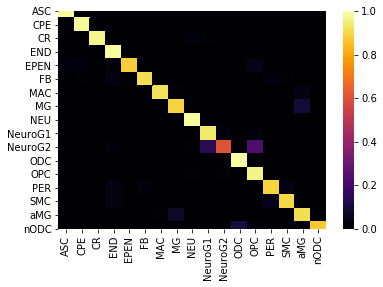

In [362]:
%matplotlib inline
import seaborn as sns
sns.heatmap(confusion_matrix_df,cmap='inferno',vmin=0,vmax=1)
# plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F5_confusion_matrix.eps', format='eps')
# plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F5_confusion_matrix.svg', format='svg')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F5_confusion_matrix.pdf')
plt.show()

In [236]:
confusion_matrix_df = pd.DataFrame(confusion_matrix,index=cell_types_idx.index,columns = cell_types_idx.index)
confusion_matrix_df.to_csv('/bigstore/GeneralStorage/Zach/CSI/F5_confusion_matrix_df.csv',compression='gzip')

In [238]:
info_df.to_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.info_df.csv')


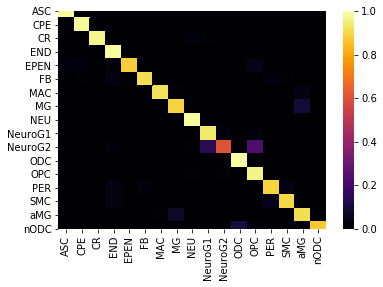

In [325]:
%matplotlib inline
import seaborn as sns
sns.heatmap(confusion_matrix_df,cmap='inferno',vmin=0,vmax=1)
# plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F5_confusion_matrix.eps', format='eps')
# plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F5_confusion_matrix.svg', format='svg')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F5_confusion_matrix.pdf')
plt.show()

Transforming to str index.
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../miniconda3/envs/pytorch/lib/python3.6/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numba/typed_passes.py:271: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

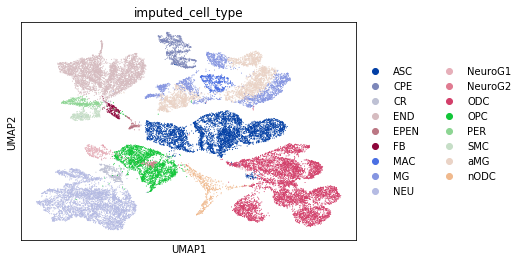

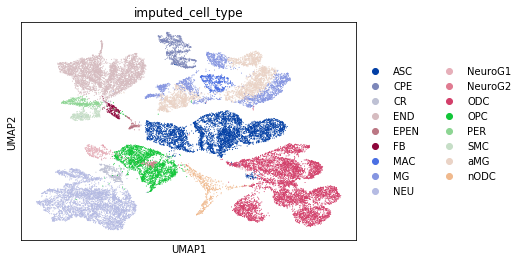

In [239]:
post_adata3 = anndata.AnnData(X=compressed)
post_adata3.obsm["matrix"] = matrix
post_adata3.obsm["X_scVI"] = np.array(latent)
post_adata3.obs['cell_type'] = np.array(info_df['cell_type'])
post_adata3.obs['imputed_cell_type'] = np.array(info_df['imputed_cell_type'])
post_adata3.obs['label'] = np.array(range(len(info_df)))
post_adata3.obs['cell'] = pd.Series(info_df.index, dtype="category")
post_adata3.obs['region'] = np.array(info_df['region'])
post_adata3.obs['dataset'] = np.array(info_df['dataset'])
post_adata3.obs['treatment'] = np.array(info_df['treatment'])
sc.pp.neighbors(post_adata3)
sc.tl.umap(post_adata3)
sc.pl.umap(post_adata3, color='imputed_cell_type')
sc.pl.umap(post_adata3, color='imputed_cell_type',save='F5b_compressed_UMAP.svg')

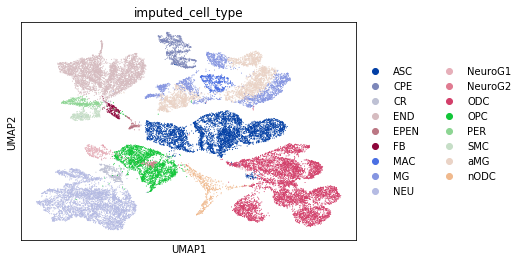

In [329]:
sc.pl.umap(post_adata3, color='imputed_cell_type',save='F5b_compressed_UMAP.pdf')

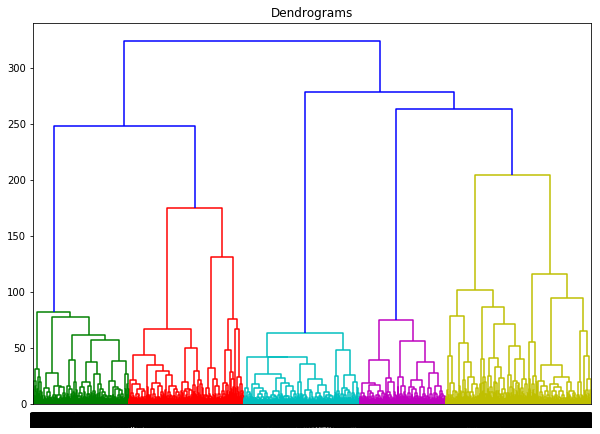

In [9]:
%matplotlib inline
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
linkage = shc.linkage(latent, method='ward',)
dend = shc.dendrogram(linkage)

In [33]:
linkage.shape

(29012, 4)

In [36]:
dend.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])

In [41]:
len(dend['icoord'])

29012

In [18]:
%matplotlib inline
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
dend = shc.dendrogram(linkage,p=1000)

Error in callback <function flush_figures at 0x7f4a2eaf0d90> (for post_execute):


KeyboardInterrupt: 

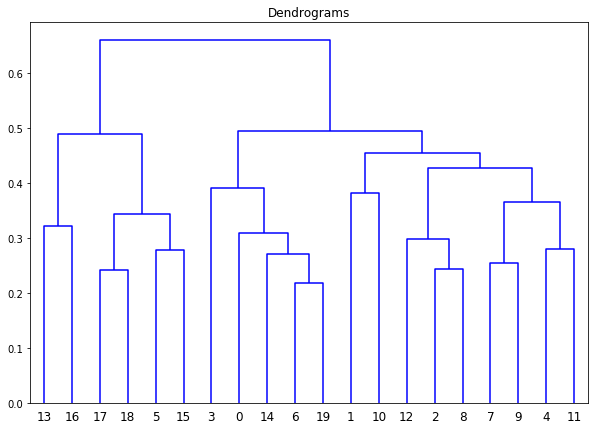

In [12]:
%matplotlib inline
import scipy.cluster.hierarchy as shc
plt.figure(figsize=(10, 7))  
plt.title("Dendrograms")
linkage2 = shc.linkage(latent.iloc[0:20], method='ward')
linkage2[:,2] = np.log10(linkage2[:,2]+1)
dend2 = shc.dendrogram(linkage2,color_threshold=0)

In [25]:
dend2.keys()

dict_keys(['icoord', 'dcoord', 'ivl', 'leaves', 'color_list'])

In [27]:
dend2['color_list']

['b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b',
 'b']

In [29]:
dend2

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [45.0, 45.0, 55.0, 55.0],
  [30.0, 30.0, 50.0, 50.0],
  [10.0, 10.0, 40.0, 40.0],
  [95.0, 95.0, 105.0, 105.0],
  [85.0, 85.0, 100.0, 100.0],
  [75.0, 75.0, 92.5, 92.5],
  [65.0, 65.0, 83.75, 83.75],
  [115.0, 115.0, 125.0, 125.0],
  [145.0, 145.0, 155.0, 155.0],
  [135.0, 135.0, 150.0, 150.0],
  [165.0, 165.0, 175.0, 175.0],
  [185.0, 185.0, 195.0, 195.0],
  [170.0, 170.0, 190.0, 190.0],
  [142.5, 142.5, 180.0, 180.0],
  [120.0, 120.0, 161.25, 161.25],
  [74.375, 74.375, 140.625, 140.625],
  [25.0, 25.0, 107.5, 107.5]],
 'dcoord': [[0.0, 0.3223896869862056, 0.3223896869862056, 0.0],
  [0.0, 0.242409400834236, 0.242409400834236, 0.0],
  [0.0, 0.27737025573831725, 0.27737025573831725, 0.0],
  [0.242409400834236,
   0.34333484063056163,
   0.34333484063056163,
   0.27737025573831725],
  [0.3223896869862056,
   0.4895856091439832,
   0.4895856091439832,
   0.34333484063056163],
  [0.0, 0.21708066822033395, 0.217080668220333

In [64]:
ncells = len(latent.iloc[0:20])
temp = linkage2.copy()
np.array([ncells+np.array(range(len(temp)))])

array([[20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
        36, 37, 38]])

In [70]:
new = np.zeros((linkage2.shape[0],linkage2.shape[1]+1))
new[:,0:4] = temp
new[:,4] = np.array([ncells+np.array(range(len(temp)))]).T[:,0]

In [74]:
new_df = pd.DataFrame(new)
new_df

,0,1,2,3,4
0,6.0,19.0,0.648469,2.0,20.0
1,17.0,18.0,0.747469,2.0,21.0
2,2.0,8.0,0.749837,2.0,22.0
3,7.0,9.0,0.796595,2.0,23.0
4,14.0,20.0,0.862429,3.0,24.0
5,5.0,15.0,0.893958,2.0,25.0
6,4.0,11.0,0.901503,2.0,26.0
7,12.0,22.0,0.987376,3.0,27.0
8,0.0,24.0,1.034346,4.0,28.0
9,13.0,16.0,1.100824,2.0,29.0


In [22]:
def find_next_node(i,df):
    temp = df[(df[0]==i)|(df[1]==i)]
    if len(temp)==1:
        return int(temp[4].iloc[0])
    else:
        return 'stop'
def linkage2binary(linkage,cells):
    ncells = len(cells)
    new_df = pd.DataFrame(linkage)
    new_df[4] = ncells+np.array(range(len(new_df)))
    binary_node_matrix = np.zeros((ncells,linkage.shape[0]+ncells))
    for i,cell in enumerate(cells):
        binary_node_matrix[i,i]=1
        new_node = find_next_node(0,new_df)
        while isinstance(new_node,int):
            binary_node_matrix[i,new_node]=1
            new_node = find_next_node(new_node,new_df)
    binary_node_df = pd.DataFrame(binary_node_matrix,index=latent.iloc[0:20].index)
    return binary_node_df
cells = list(latent.iloc[0:20].index)
binary_node_df = linkage2binary(linkage2,cells)
binary_node_df

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
S1Hip_CCTTGCCACACT_ODC,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
S1Hip_TTCTATTCGTAG_ODC,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
S1Hip_TTGGGCCCACCG_ODC,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
S1Hip_ATGTACGCCGTG_ODC,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
S1Hip_CCAGAATAATTT_ODC,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
S1Hip_CCGCTCAAGTCC_ODC,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
S1Hip_GGAGGATTGGGT_ODC,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
S1Hip_AGTCACTGTTTA_ODC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
S1Hip_TAAAACCTATCG_ODC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
S1Hip_CCGTCCCGAGTT_ODC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0


In [ ]:
linkage = shc.linkage(latent, method='ward')

In [31]:
pd.DataFrame(linkage).to_csv('/bigstore/GeneralStorage/Zach/CSI/linkage.csv')

In [3]:
linkage = np.array(pd.read_csv('/bigstore/GeneralStorage/Zach/CSI/linkage.csv',index_col=0))
linkage.shape

(29012, 4)

In [5]:
import tqdm.notebook as tqdm
def find_next_node(i,df):
    temp = df[(df[0]==i)|(df[1]==i)]
    if len(temp)==1:
        return int(temp[4].iloc[0])
    else:
        return 'stop'
def linkage2binary(linkage,cells):
    ncells = len(cells)
    new_df = pd.DataFrame(linkage)
    new_df[4] = ncells+np.array(range(len(new_df)))
    binary_node_matrix = np.zeros((ncells,linkage.shape[0]+ncells))
    for i in tqdm.tqdm(range(ncells)):
        binary_node_matrix[i,i]=1
        new_node = find_next_node(i,new_df)
        while isinstance(new_node,int):
            binary_node_matrix[i,new_node]=1
            new_node = find_next_node(new_node,new_df)
    binary_node_df = pd.DataFrame(binary_node_matrix,index=cells)
    return binary_node_df

cells = list(latent.index)
binary_node_df_full = linkage2binary(linkage,cells)
binary_node_df_full

KeyboardInterrupt: 

In [9]:
import tqdm.notebook as tqdm
from multiprocessing import Pool
import sys
from functools import partial

In [12]:
def find_next_node(i,df):
    temp = df[(df[0]==i)|(df[1]==i)]
    if len(temp)==1:
        return int(temp[4].iloc[0])
    else:
        return 'stop'
def find_nodes(i,new_df):
    n = []
    new_node = find_next_node(i,new_df)
    n.append(i)
    while isinstance(new_node,int):
            n.append(new_node)
            new_node = find_next_node(new_node,new_df)
    return n

def linkage2binary(linkage,cells):
    ncells = len(cells)
    new_df = pd.DataFrame(linkage)
    new_df[4] = ncells+np.array(range(len(new_df)))
    binary_node_matrix = np.zeros((ncells,linkage.shape[0]+ncells))
    sys.stdout.flush()
    pfunc = partial(find_nodes,new_df=new_df)
    with Pool(30) as p:
        for nodes in tqdm.tqdm(p.imap(pfunc,list(range(ncells)),chunksize=1),total=ncells):
            i = nodes[0]
            for n in nodes:
                binary_node_matrix[i,n]=1
    sys.stdout.flush()
    binary_node_df = pd.DataFrame(binary_node_matrix,index=cells)
    return binary_node_df
cells = list(latent.index)
binary_node_df_full = linkage2binary(linkage,cells)
binary_node_df_full

,0,1,2,3,4,5,6,7,8,9,...,58015,58016,58017,58018,58019,58020,58021,58022,58023,58024
S1Hip_CCTTGCCACACT_ODC,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
S1Hip_TTCTATTCGTAG_ODC,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
S1Hip_TTGGGCCCACCG_ODC,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
S1Hip_ATGTACGCCGTG_ODC,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
S1Hip_CCAGAATAATTT_ODC,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBI5Hip_GGTATTGACACC_EPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
TBI5Hip_TCCCACGCCAAC_EPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
TBI5Hip_TTCCTGTAGACC_EPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
TBI5Hip_ATTTAATTGAGC_EPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [13]:
binary_node_df_full.to_csv('/bigstore/GeneralStorage/Zach/CSI/binary_node_df_full.csv')

KeyboardInterrupt: 

In [15]:
from scipy.sparse import csr_matrix
binary_node_df_full_Sparse = csr_matrix(np.array(binary_node_df_full))

In [16]:
pickle.dump(binary_node_df_full_Sparse,open('/bigstore/GeneralStorage/Zach/CSI/binary_node_df_full_Sparse.pkl','wb'))

In [ ]:
# for every cell find its nearest neighbor
# new df with predicted binary node df
# for each node what % are correct FP and FN
# 

In [18]:
import pickle
compressed = pickle.load(open('/bigstore/GeneralStorage/Zach/CSI/imputation/compresseds_71.pkl','rb'))[0]
compressed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
S1Hip_CCTTGCCACACT_ODC,821.918125,1275.621649,2023.892946,564.336762,2766.193444,979.913834,573.528390,1449.225769,1610.395464,1062.243541,1929.619184,728.161547,396.497565,1782.986125,4857.577561,2789.990196,930.132438,1501.283197
S1Hip_TTCTATTCGTAG_ODC,777.732448,1177.191945,2460.911270,497.772675,3037.356598,1027.485798,453.572433,1336.966993,1502.570891,1000.850164,1402.648841,648.258898,335.266369,2456.210384,5480.120927,3119.417623,874.084371,1375.344763
S1Hip_TTGGGCCCACCG_ODC,1063.189820,1008.472844,1735.680039,568.672077,2206.935534,1209.953320,586.384450,1287.137605,1685.233470,971.355418,1771.049229,704.529455,422.255837,1768.438358,4385.772654,2709.161911,1025.454290,1246.036536
S1Hip_ATGTACGCCGTG_ODC,858.660196,1395.460536,2587.125801,743.962442,2753.159942,1135.792431,539.393519,1212.377240,1609.763219,1240.505110,2151.556299,754.837826,433.555412,1921.102380,5097.989225,3082.822347,930.844342,1627.590879
S1Hip_CCAGAATAATTT_ODC,1082.956479,1300.174808,1981.696497,619.344753,2511.610847,1244.694965,581.438139,1407.742103,1687.196541,1043.949242,1824.395350,723.098859,449.219288,2257.208186,4703.753952,3105.242613,962.292099,1419.995250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBI5Hip_GGTATTGACACC_EPEN,1302.335445,1337.537227,1317.076138,2058.593585,1632.088089,1694.863750,1724.487481,1522.503761,1442.141216,1199.055872,1917.745995,832.156639,945.418578,694.368466,2771.918991,1216.615130,1244.315418,2389.331406
TBI5Hip_TCCCACGCCAAC_EPEN,1249.658731,1395.052938,1260.783831,2245.217945,2084.379002,1645.222193,1441.372579,1682.008960,1647.023928,1518.392715,1520.041472,968.366971,1036.952945,1026.929038,1748.621490,1165.567635,1399.986745,1615.093804
TBI5Hip_TTCCTGTAGACC_EPEN,1316.329993,1329.707273,1270.312788,1982.639349,2384.853156,1669.510975,1439.820864,1641.914626,1658.310553,1400.617645,1433.607040,1003.936191,941.307976,958.709527,1809.842153,1314.473953,1390.295772,1598.341624
TBI5Hip_ATTTAATTGAGC_EPEN,1312.259839,1489.739724,1280.486833,2016.747973,2006.949422,1734.211082,1485.528458,1606.840139,1746.871499,1310.278713,1648.079566,1028.993104,1032.747628,919.868714,2172.952398,1348.392175,1368.461342,1739.963244


In [19]:
from sklearn.metrics.pairwise import euclidean_distances
X = np.array(compressed.copy())
cells = np.array(latent.index)
ncells = len(cells)
k = 1
dist = euclidean_distances(X, X)
rank = dist.argpartition(k+1,axis=0)[:k+1,:]
metrics = []
correlations = []
imputed_binary_node_df_full = binary_node_df_full.copy()

KeyboardInterrupt: 

In [52]:
for x in tqdm.tqdm(range(ncells)):
    cell = cells[x]
    imputed_binary_node_df_full.loc[cell] = binary_node_df_full.loc[cells[rank[1,x]]]

In [53]:
imputed_binary_node_df_full

,0,1,2,3,4,5,6,7,8,9,...,58015,58016,58017,58018,58019,58020,58021,58022,58023,58024
S1Hip_CCTTGCCACACT_ODC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
S1Hip_TTCTATTCGTAG_ODC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
S1Hip_TTGGGCCCACCG_ODC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
S1Hip_ATGTACGCCGTG_ODC,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
S1Hip_CCAGAATAATTT_ODC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBI5Hip_GGTATTGACACC_EPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
TBI5Hip_TCCCACGCCAAC_EPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
TBI5Hip_TTCCTGTAGACC_EPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0
TBI5Hip_ATTTAATTGAGC_EPEN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0


In [54]:
accuracy_matrix = np.zeros(len(imputed_binary_node_df_full.columns))
false_positive_rate_matrix = np.zeros(len(imputed_binary_node_df_full.columns))
false_negative_rate_matrix = np.zeros(len(imputed_binary_node_df_full.columns))
for i in tqdm.tqdm(imputed_binary_node_df_full.columns):
    imputed_cells = list(imputed_binary_node_df_full[imputed_binary_node_df_full[i]==1].index)
    truth_cells = list(binary_node_df_full[binary_node_df_full[i]==1].index)
    true = len(set(imputed_cells).intersection(truth_cells))
    fp = len(imputed_cells)-true
    fn = len(truth_cells)-true
    ltruth = len(truth_cells)
    accuracy_matrix[i] = true/ltruth
    false_positive_rate_matrix[i] = fp/ltruth
    false_negative_rate_matrix[i] = fn/ltruth

(array([48172.,  1485.,  2233.,  1639.,  1018.,  1640.,   767.,   222.,
          121.,   728.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

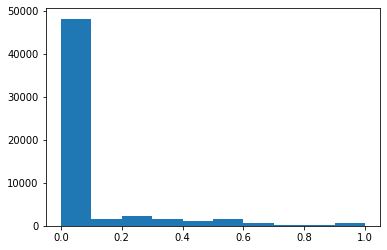

In [55]:
plt.hist(accuracy_matrix)

(array([2.3373e+04, 2.1058e+04, 1.0157e+04, 6.8000e+02, 2.0790e+03,
        5.6200e+02, 2.0000e+00, 9.8000e+01, 1.4000e+01, 2.0000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <a list of 10 Patch objects>)

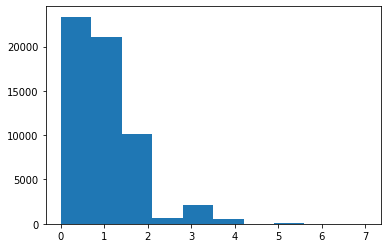

In [56]:
plt.hist(false_positive_rate_matrix)

(array([  727.,    71.,   284.,   756.,   477.,  2181.,  1736.,  1675.,
         1850., 48268.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

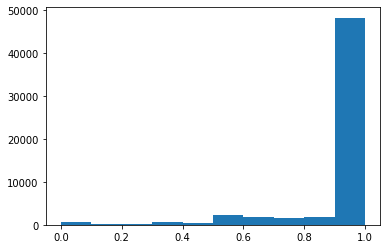

In [57]:
plt.hist(false_negative_rate_matrix)

In [48]:
i=1
imputed_cells = list(imputed_binary_node_df_full[imputed_binary_node_df_full[i]==1].index)
truth_cells = list(binary_node_df_full[binary_node_df_full[i]==1].index)
true = len(set(imputed_cells).intersection(truth_cells))
fp = len(imputed_cells)-true
fn = len(truth_cells)-true
ltruth = len(truth_cells)

In [ ]:
from matplotlib import cm
cmap = cm.get_cmap('Reds', 12)

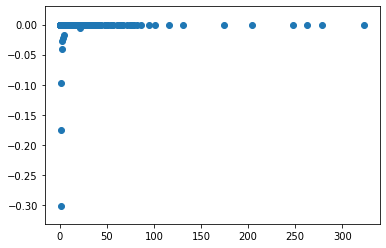

In [68]:
plt.scatter(linkage[:,2],accuracy[-len(linkage[:,2]):])

In [63]:
len(accuracy[ncells:])

28324

In [59]:
len(linkage[:,2])

29012

In [70]:
linkage.shape

(29012, 4)

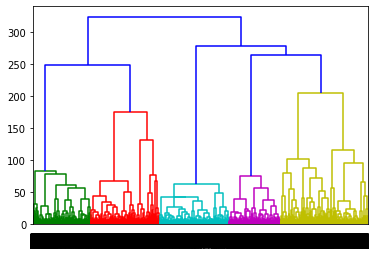

In [73]:
D = shc.dendrogram(Z=Z,p=20)

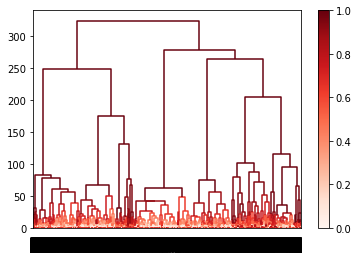

In [80]:
import random
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.cluster.hierarchy as shc
Z = linkage
accuracy = accuracy_matrix
# accuracy = accuracy-np.min(accuracy)
accuracy = accuracy#/np.max(accuracy)
cmap = cm.Reds(accuracy)
temp = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]
link_cols = {}
for i,c in enumerate(temp):
    link_cols[i] = c
D = shc.dendrogram(Z=Z,p=20, link_color_func=lambda x: link_cols[x])
plt.colorbar(cm.ScalarMappable(cmap='Reds'))
plt.show()

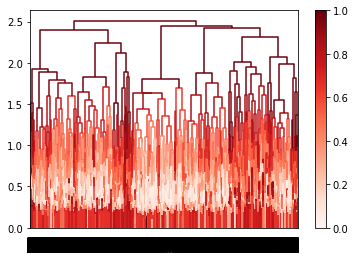

In [81]:
import random
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.cluster.hierarchy as shc
Z = linkage.copy()
Z[:,2] = np.log10(Z[:,2]+1)
accuracy = accuracy_matrix
# accuracy = accuracy-np.min(accuracy)
accuracy = accuracy#/np.max(accuracy)
cmap = cm.Reds(accuracy)
temp = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]
link_cols = {}
for i,c in enumerate(temp):
    link_cols[i] = c
D = shc.dendrogram(Z=Z,p=20, link_color_func=lambda x: link_cols[x])
plt.colorbar(cm.ScalarMappable(cmap='Reds'))
plt.show()

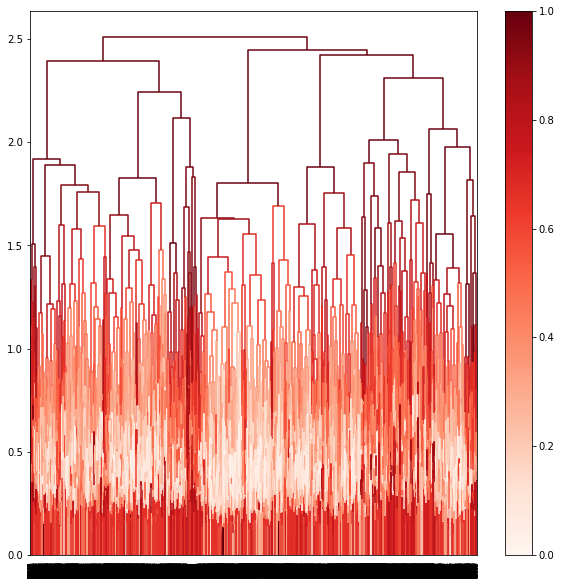

In [86]:
import random
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.cluster.hierarchy as shc
Z = linkage.copy()
Z[:,2] = np.log10(Z[:,2]+1)
accuracy = accuracy_matrix
# accuracy = accuracy-np.min(accuracy)
accuracy = accuracy#/np.max(accuracy)
cmap = cm.Reds(accuracy)
temp = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]
link_cols = {}
for i,c in enumerate(temp):
    link_cols[i] = c
plt.figure(figsize=[10,10])
D = shc.dendrogram(Z=Z,p=1, link_color_func=lambda x: link_cols[x])
plt.colorbar(cm.ScalarMappable(cmap='Reds'))
plt.show()

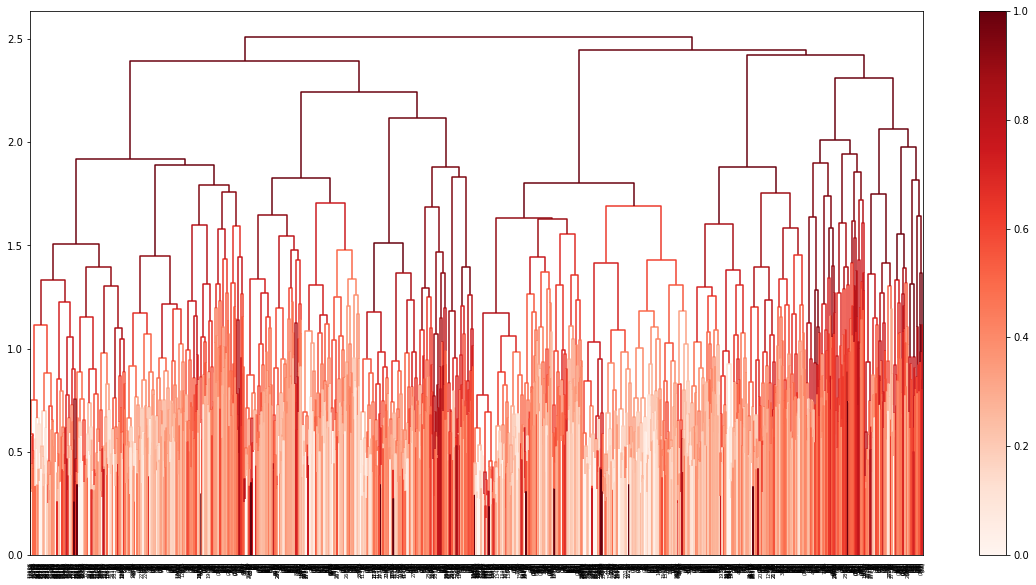

In [88]:
import random
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.cluster.hierarchy as shc
Z = linkage.copy()
Z[:,2] = np.log10(Z[:,2]+1)
accuracy = accuracy_matrix
# accuracy = accuracy-np.min(accuracy)
accuracy = accuracy#/np.max(accuracy)
cmap = cm.Reds(accuracy)
temp = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]
link_cols = {}
for i,c in enumerate(temp):
    link_cols[i] = c
plt.figure(figsize=[20,10])
D = shc.dendrogram(Z=Z,p=10,truncate_mode='level',link_color_func=lambda x: link_cols[x])
plt.colorbar(cm.ScalarMappable(cmap='Reds'))
plt.show()

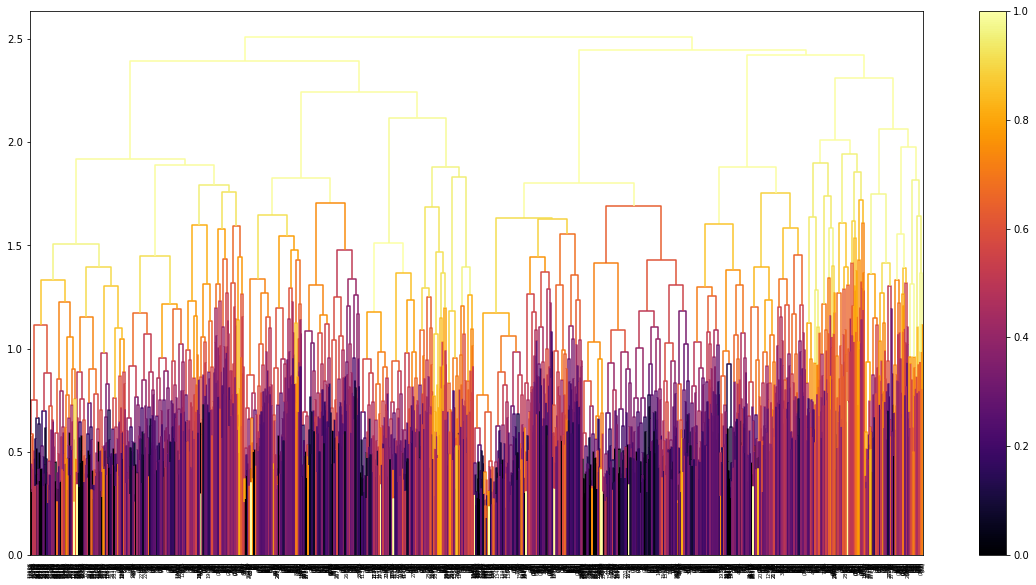

In [89]:
import random
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.cluster.hierarchy as shc
Z = linkage.copy()
Z[:,2] = np.log10(Z[:,2]+1)
accuracy = accuracy_matrix
# accuracy = accuracy-np.min(accuracy)
accuracy = accuracy#/np.max(accuracy)
cmap = cm.inferno(accuracy)
temp = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]
link_cols = {}
for i,c in enumerate(temp):
    link_cols[i] = c
plt.figure(figsize=[20,10])
D = shc.dendrogram(Z=Z,p=10,truncate_mode='level',link_color_func=lambda x: link_cols[x])
plt.colorbar(cm.ScalarMappable(cmap='inferno'))
plt.show()

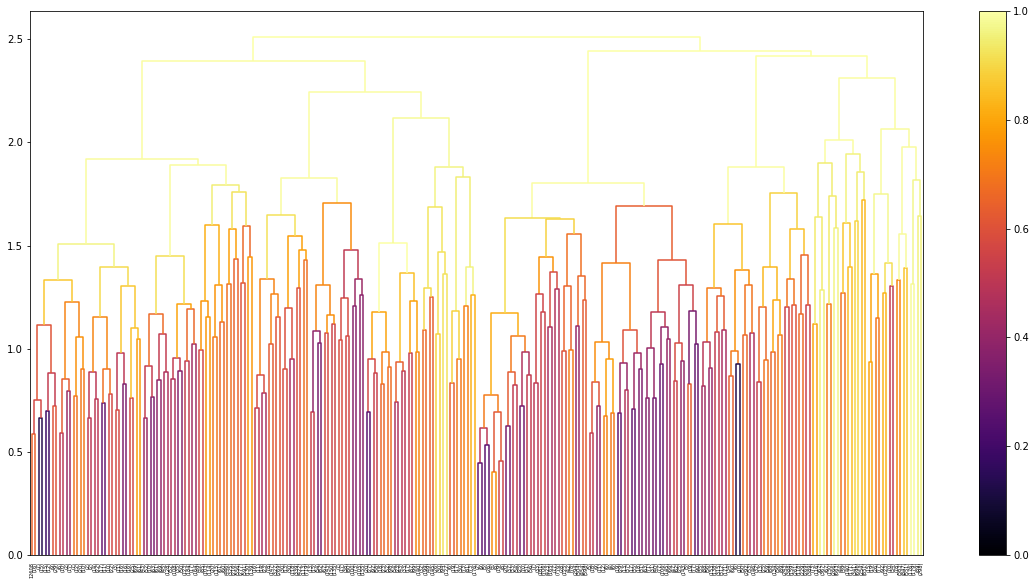

In [91]:
import random
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.cluster.hierarchy as shc
Z = linkage.copy()
Z[:,2] = np.log10(Z[:,2]+1)
accuracy = accuracy_matrix
# accuracy = accuracy-np.min(accuracy)
accuracy = accuracy#/np.max(accuracy)
cmap = cm.inferno(accuracy)
temp = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]
link_cols = {}
for i,c in enumerate(temp):
    link_cols[i] = c
plt.figure(figsize=[20,10])
D = shc.dendrogram(Z=Z,p=7,truncate_mode='level',link_color_func=lambda x: link_cols[x])
plt.colorbar(cm.ScalarMappable(cmap='inferno'))
plt.show()

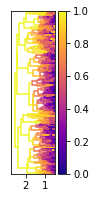

In [370]:
%matplotlib inline
import random
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy.cluster.hierarchy as shc
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
Z = linkage.copy()
Z[:,2] = np.log10(Z[:,2]+1)
accuracy = accuracy_matrix
# accuracy = accuracy-np.min(accuracy)
accuracy = accuracy#/np.max(accuracy)
cmap = cm.plasma(accuracy)
temp = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]
link_cols = {}
for i,c in enumerate(temp):
    link_cols[i] = c
plt.figure(figsize=[1,3])
D = shc.dendrogram(Z=Z,
                   link_color_func=lambda x: link_cols[x],
                   orientation='left',no_labels=True)
plt.xlim([2.75,0.5])
# c_ax=plt.subplot(199)
# cb = matplotlib.colorbar.ColorbarBase(c_ax,cmap='plasma',orientation='vertical')
# c_ax.yaxis.set_ticks_position('left')
# cbaxes = fig.add_axes([0.1, 0.2, 0.03, 0.8]) 
plt.colorbar(cm.ScalarMappable(cmap='plasma'),orientation="vertical")
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F6a_dendrogram.svg')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F6a_dendrogram.pdf')
plt.show()

In [107]:
len(D['leaves'])

29013

In [108]:
compressed.shape

(29013, 18)

In [115]:
sorted_compressed = np.zeros_like(compressed)
temp = np.array(compressed)
cells = list(compressed.index)
new_cells = []
for i,old in enumerate(D['leaves']):
    new_cells.append(cells[i])
    sorted_compressed[i,:] = temp[old,:]
sorted_compressed_df = pd.DataFrame(sorted_compressed,index=new_cells)
sorted_compressed_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
S1Hip_CCTTGCCACACT_ODC,2681.812611,1422.013232,2560.884647,1001.720931,1548.318935,2193.237533,1987.231491,2041.634963,1772.529027,703.335736,1454.454916,1094.857103,1545.203055,595.320197,2911.395193,1790.732687,1063.983994,1135.520036
S1Hip_TTCTATTCGTAG_ODC,2781.784072,1434.488661,2825.486105,725.025691,2032.569437,2205.633156,2348.566425,1549.612607,1963.864240,860.084051,1244.701329,1389.877532,1561.524136,738.209840,2891.056349,1555.026874,1364.781963,1415.468447
S1Hip_TTGGGCCCACCG_ODC,3481.295829,1108.244928,2358.034192,658.374519,1967.784299,2698.684082,2268.029998,1470.069941,2011.395122,672.101319,1120.522779,1131.100668,2360.003737,634.322782,3162.603400,1345.737389,1143.768363,1137.004416
S1Hip_ATGTACGCCGTG_ODC,2049.693223,1451.229512,2874.469955,701.349514,1878.686757,2527.120315,1938.844458,1296.292712,1529.700213,710.239944,1203.875461,1260.133171,1028.552893,1090.735600,3020.428054,1700.242157,1230.142159,1153.730562
S1Hip_CCAGAATAATTT_ODC,2714.446641,1253.213114,2824.313618,645.666302,1676.343554,2110.157015,2199.029230,1482.477876,1653.723014,720.289187,1331.959930,1355.368528,1715.525272,547.160289,2796.035411,1557.237208,1146.526181,1155.004393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBI5Hip_GGTATTGACACC_EPEN,3568.453676,1689.135305,1277.481577,813.633778,1858.221216,2809.149682,2359.894665,1757.565377,1016.968834,780.370193,1265.244221,675.580037,1229.259021,714.591975,2477.149900,1384.749545,1129.581665,2223.020763
TBI5Hip_TCCCACGCCAAC_EPEN,3981.900226,1859.970837,1198.948750,1192.478618,1518.202485,3652.087035,4749.829847,1923.081540,1131.661768,984.944069,1424.233736,780.844800,1444.000575,733.161797,2830.765307,1485.488559,1536.033762,2421.096896
TBI5Hip_TTCCTGTAGACC_EPEN,3211.250618,1224.007680,1436.785986,703.859791,1559.206475,4298.650566,2720.950489,1357.950590,962.166674,797.297751,1110.024590,598.608292,1522.599305,504.823906,2093.196594,1006.442444,1359.539249,2326.597696
TBI5Hip_ATTTAATTGAGC_EPEN,3097.004305,1586.526753,1604.834699,889.919686,1736.750191,3196.094178,2650.620043,1713.322532,1186.299777,884.330249,1318.920213,830.894176,1506.128011,602.072580,2484.290417,1387.208615,1195.615443,2819.715261


In [172]:
np.log10(np.percentile(np.array(sorted_compressed_df).ravel(),95))

3.5411572638409075

In [241]:
sorted_compressed_df.to_csv('/bigstore/GeneralStorage/Zach/CSI/sorted_compressed_df.csv',compression='gzip')

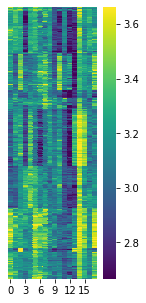

In [324]:
import seaborn as sns
plt.figure(figsize=[2,5])
vmax = np.log10(np.percentile(np.array(sorted_compressed_df).ravel(),99))
vmin = np.log10(np.percentile(np.array(sorted_compressed_df).ravel(),1))
sns.heatmap(np.log10(sorted_compressed_df),cmap='viridis',yticklabels=False,vmax=vmax,vmin=vmin)
# plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F6b_sorted_compressed_heatmap.eps', format='eps')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F6b_sorted_compressed_heatmap.pdf')
# plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F6b_sorted_compressed_heatmap.svg', format='svg')
plt.show()

In [129]:
node_df = pd.DataFrame(index=binary_node_df_full.columns)
node_df['accuracy'] = accuracy
node_df['false_negative_rate'] = false_negative_rate_matrix
node_df['false_positive_rate'] = false_positive_rate_matrix
node_df['ncells'] = np.sum(binary_node_df_full,axis=0)
node_df

,accuracy,false_negative_rate,false_positive_rate,ncells
0,0.000000,1.000000,1.000000,1.0
1,0.000000,1.000000,1.000000,1.0
2,0.000000,1.000000,1.000000,1.0
3,0.000000,1.000000,1.000000,1.0
4,0.000000,1.000000,2.000000,1.0
...,...,...,...,...
58020,0.995890,0.004110,0.004641,7542.0
58021,0.995714,0.004286,0.003466,10965.0
58022,0.996337,0.003663,0.005244,12013.0
58023,0.997895,0.002105,0.002604,18048.0


In [159]:
x1 = np.unique(node_df['ncells'])
y1 = []
s1 = []
for n in x1:
    temp_df = node_df[node_df['ncells']==n]
    y1.append(np.mean(temp_df['accuracy']))
    s1.append(np.std(temp_df['accuracy']))

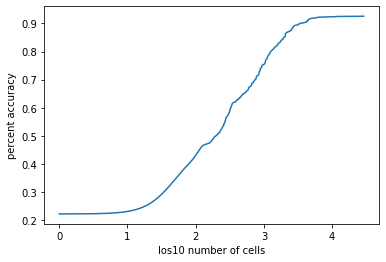

In [163]:
from scipy.ndimage import gaussian_filter
plt.plot(np.log10(x1),gaussian_filter(y1,20))
plt.xlabel('log10 number of cells')
plt.ylabel('percent accuracy')
plt.show()

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


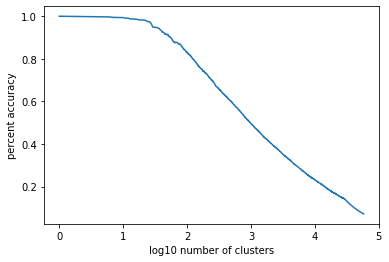

In [154]:
x = range(0,len(node_df))
y = []
for n in x:
    temp = node_df.iloc[-n:]
    y.append(np.average(temp['accuracy']))
plt.plot(np.log10(x),y)
plt.xlabel('log10 number of clusters')
plt.ylabel('percent accuracy')
plt.show()

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


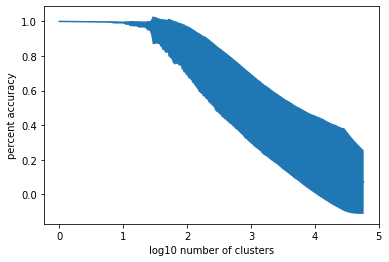

In [155]:
x = range(0,len(node_df))
y = []
s = []
for n in x:
    temp = node_df.iloc[-n:]
    y.append(np.average(temp['accuracy']))
    s.append(np.std(temp['accuracy']))
plt.plot(np.log10(x),y)
plt.fill_between(np.log10(x), np.array(y)-s, np.array(y)+s)
plt.xlabel('log10 number of clusters')
plt.ylabel('percent accuracy')
plt.show()

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


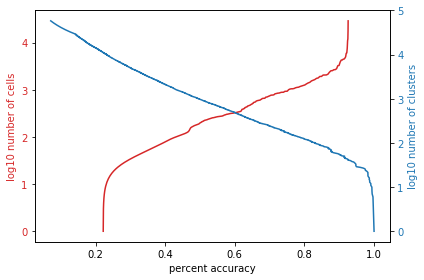

In [166]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('percent accuracy')
ax1.set_ylabel('log10 number of cells', color=color)
ax1.plot(gaussian_filter(y1,20), np.log10(x1), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('log10 number of clusters', color=color)  # we already handled the x-label with ax1
ax2.plot(y, np.log10(x), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10


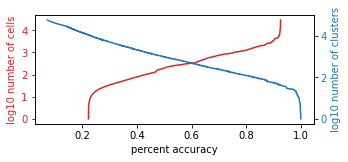

In [243]:
x = range(0,len(node_df))
y = []
for n in x:
    temp = node_df.iloc[-n:]
    y.append(np.average(temp['accuracy']))
x1 = np.unique(node_df['ncells'])
y1 = []
s1 = []
for n in x1:
    temp_df = node_df[node_df['ncells']==n]
    y1.append(np.mean(temp_df['accuracy']))
    s1.append(np.std(temp_df['accuracy']))
fig, ax1 = plt.subplots(figsize=[5,2])
color = 'tab:red'
ax1.set_xlabel('percent accuracy')
ax1.set_ylabel('log10 number of cells', color=color)
ax1.plot(gaussian_filter(y1,20), np.log10(x1), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('log10 number of clusters', color=color)  # we already handled the x-label with ax1
ax2.plot(y, np.log10(x), color=color)
ax2.tick_params(axis='y', labelcolor=color)

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.colorbar(cm.ScalarMappable(cmap='plasma'),orientation="horizontal")
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F6c_dendrogram_accuracy.eps', format='eps')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F6c_dendrogram_accuracy.svg', format='svg')
plt.show()

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in log10


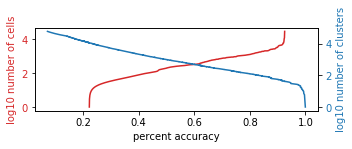

In [322]:
x = range(0,len(node_df))
y = []
for n in x:
    temp = node_df.iloc[-n:]
    y.append(np.average(temp['accuracy']))
x1 = np.unique(node_df['ncells'])
y1 = []
s1 = []
for n in x1:
    temp_df = node_df[node_df['ncells']==n]
    y1.append(np.mean(temp_df['accuracy']))
    s1.append(np.std(temp_df['accuracy']))
fig, ax1 = plt.subplots(figsize=[5,2])
color = 'tab:red'
ax1.set_xlabel('percent accuracy')
ax1.set_ylabel('log10 number of cells', color=color)
ax1.plot(gaussian_filter(y1,20), np.log10(x1), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('log10 number of clusters', color=color)  # we already handled the x-label with ax1
ax2.plot(y, np.log10(x), color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
# plt.colorbar(cm.ScalarMappable(cmap='plasma'),orientation="horizontal")
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F6c_dendrogram_accuracy.eps', format='eps')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F6c_dendrogram_accuracy.svg', format='svg')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F6c_dendrogram_accuracy.pdf')
plt.show()

In [246]:
SCMatrix_preprocessed = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.SCMatrix_preprocessed.csv.gz',index_col=0)

In [247]:
SCMatrix_preprocessed

,S1Hip_CCTTGCCACACT_ODC,S1Hip_TTCTATTCGTAG_ODC,S1Hip_TTGGGCCCACCG_ODC,S1Hip_ATGTACGCCGTG_ODC,S1Hip_CCAGAATAATTT_ODC,S1Hip_CCGCTCAAGTCC_ODC,S1Hip_GGAGGATTGGGT_ODC,S1Hip_AGTCACTGTTTA_ODC,S1Hip_TAAAACCTATCG_ODC,S1Hip_CCGTCCCGAGTT_ODC,...,TBI5Hip_TCCTGAGACGCT_EPEN,TBI5Hip_TTGCGCAAAACG_EPEN,TBI5Hip_ACGCCGAGTTGC_EPEN,TBI5Hip_CAGCATATGGCG_EPEN,TBI5Hip_GACATCATTCAT_EPEN,TBI5Hip_GGTATTGACACC_EPEN,TBI5Hip_TCCCACGCCAAC_EPEN,TBI5Hip_TTCCTGTAGACC_EPEN,TBI5Hip_ATTTAATTGAGC_EPEN,TBI5Hip_ATCCCTCGCAGC_EPEN
S100a8,2.364784,1.461975,5.391096,2.509546,4.712524,3.768372,3.398080,1.985958,1.851293,1.444066,...,39.517119,15.271486,37.562048,12.583853,13.415616,11.784147,27.445561,20.220385,14.600374,53.748689
S100a9,7.980294,5.745429,21.338277,9.668505,16.653468,8.456556,11.952849,6.803702,8.912395,5.577855,...,12.737410,13.524374,28.377019,11.633263,7.572255,7.296736,20.328600,16.262575,9.789528,39.593735
Cd74,10.741047,9.227930,13.273919,9.146592,12.799319,11.450016,14.036164,7.856625,6.947047,5.647035,...,0.538771,0.328390,0.334835,0.144499,1.152239,1.003730,0.360613,0.305442,0.468544,0.747466
Igfbpl1,2.559000,3.063422,6.540781,3.762574,6.495443,8.464190,3.924460,4.838439,5.354334,4.269884,...,21.730695,18.055809,12.546088,10.939027,24.903960,13.431865,14.821945,17.965363,24.990080,17.317838
Ccdc153,4.402882,0.920499,4.617224,3.669908,2.764918,6.075985,3.444847,5.254631,5.509724,3.005932,...,686.168438,811.829465,1850.815723,1970.840851,412.212219,219.295325,1919.269795,1976.343105,1140.786102,620.182953
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Dennd2a,21.008136,15.200448,20.794192,19.749592,18.843310,30.059371,21.917194,31.879263,20.997079,20.511752,...,65.227752,76.421755,42.222604,53.564880,90.595837,111.972622,65.528620,58.062476,79.117744,40.098272
Pvrl3,8.316034,8.897811,12.092312,9.833864,10.691897,12.753818,10.506978,12.957983,10.947870,9.475601,...,117.812393,120.669632,60.458908,49.490187,143.445577,121.553137,58.618974,50.532388,85.759748,48.851143
Gm15246,12.858672,14.008999,18.482569,20.585436,17.919301,12.484151,20.097286,22.369684,18.804381,17.860597,...,9.179182,25.414009,11.257293,12.075464,31.856613,11.659271,14.918556,13.707717,17.512190,9.529531
Garnl3,29.194127,17.122771,27.018212,24.429482,28.382714,23.764263,32.912420,26.619982,25.767877,24.597301,...,36.432262,86.740431,38.644615,35.002970,90.464520,38.413200,43.317683,47.249316,63.238622,45.821474


In [260]:
compressed = pickle.load(open('/bigstore/GeneralStorage/Zach/CSI/imputation/compresseds_71.pkl','rb'))[0]
compressed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
S1Hip_CCTTGCCACACT_ODC,821.918125,1275.621649,2023.892946,564.336762,2766.193444,979.913834,573.528390,1449.225769,1610.395464,1062.243541,1929.619184,728.161547,396.497565,1782.986125,4857.577561,2789.990196,930.132438,1501.283197
S1Hip_TTCTATTCGTAG_ODC,777.732448,1177.191945,2460.911270,497.772675,3037.356598,1027.485798,453.572433,1336.966993,1502.570891,1000.850164,1402.648841,648.258898,335.266369,2456.210384,5480.120927,3119.417623,874.084371,1375.344763
S1Hip_TTGGGCCCACCG_ODC,1063.189820,1008.472844,1735.680039,568.672077,2206.935534,1209.953320,586.384450,1287.137605,1685.233470,971.355418,1771.049229,704.529455,422.255837,1768.438358,4385.772654,2709.161911,1025.454290,1246.036536
S1Hip_ATGTACGCCGTG_ODC,858.660196,1395.460536,2587.125801,743.962442,2753.159942,1135.792431,539.393519,1212.377240,1609.763219,1240.505110,2151.556299,754.837826,433.555412,1921.102380,5097.989225,3082.822347,930.844342,1627.590879
S1Hip_CCAGAATAATTT_ODC,1082.956479,1300.174808,1981.696497,619.344753,2511.610847,1244.694965,581.438139,1407.742103,1687.196541,1043.949242,1824.395350,723.098859,449.219288,2257.208186,4703.753952,3105.242613,962.292099,1419.995250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TBI5Hip_GGTATTGACACC_EPEN,1302.335445,1337.537227,1317.076138,2058.593585,1632.088089,1694.863750,1724.487481,1522.503761,1442.141216,1199.055872,1917.745995,832.156639,945.418578,694.368466,2771.918991,1216.615130,1244.315418,2389.331406
TBI5Hip_TCCCACGCCAAC_EPEN,1249.658731,1395.052938,1260.783831,2245.217945,2084.379002,1645.222193,1441.372579,1682.008960,1647.023928,1518.392715,1520.041472,968.366971,1036.952945,1026.929038,1748.621490,1165.567635,1399.986745,1615.093804
TBI5Hip_TTCCTGTAGACC_EPEN,1316.329993,1329.707273,1270.312788,1982.639349,2384.853156,1669.510975,1439.820864,1641.914626,1658.310553,1400.617645,1433.607040,1003.936191,941.307976,958.709527,1809.842153,1314.473953,1390.295772,1598.341624
TBI5Hip_ATTTAATTGAGC_EPEN,1312.259839,1489.739724,1280.486833,2016.747973,2006.949422,1734.211082,1485.528458,1606.840139,1746.871499,1310.278713,1648.079566,1028.993104,1032.747628,919.868714,2172.952398,1348.392175,1368.461342,1739.963244


In [249]:
SCMatrix = pd.read_csv('/bigstore/binfo/mouse/Hippocampus/TBI.SHAM.countdata.with.celltypes.relavent_normalized_df.csv.gz',index_col=0)


In [250]:
SCMatrix

,S1Hip_CCTTGCCACACT_ODC,S1Hip_TTCTATTCGTAG_ODC,S1Hip_TTGGGCCCACCG_ODC,S1Hip_ATGTACGCCGTG_ODC,S1Hip_CCAGAATAATTT_ODC,S1Hip_CCGCTCAAGTCC_ODC,S1Hip_GGAGGATTGGGT_ODC,S1Hip_AGTCACTGTTTA_ODC,S1Hip_TAAAACCTATCG_ODC,S1Hip_CCGTCCCGAGTT_ODC,...,TBI5Hip_TCCTGAGACGCT_EPEN,TBI5Hip_TTGCGCAAAACG_EPEN,TBI5Hip_ACGCCGAGTTGC_EPEN,TBI5Hip_CAGCATATGGCG_EPEN,TBI5Hip_GACATCATTCAT_EPEN,TBI5Hip_GGTATTGACACC_EPEN,TBI5Hip_TCCCACGCCAAC_EPEN,TBI5Hip_TTCCTGTAGACC_EPEN,TBI5Hip_ATTTAATTGAGC_EPEN,TBI5Hip_ATCCCTCGCAGC_EPEN
Reps1,44.327400,36.272220,32.044081,49.884129,44.007866,63.792635,46.131809,59.826943,30.186640,48.974824,...,27.059303,70.520451,42.396328,62.709747,79.230260,34.090790,50.830931,40.293966,42.555861,22.970220
Soga3,123.398349,109.782974,136.354924,148.335690,152.976922,162.084616,140.642354,140.650256,132.285044,125.673556,...,180.996343,174.757413,103.136088,95.595831,239.053974,203.634831,126.504427,153.332090,203.838630,149.677478
Rps15,618.085382,528.949604,571.626879,491.853862,525.095733,691.627967,551.121717,458.639552,477.108551,484.201359,...,214.221203,182.518139,355.961500,282.744382,92.910159,186.528589,264.676928,331.825169,218.183457,429.976790
Anks1b,459.308503,522.124406,609.744049,543.028407,531.675178,521.985290,563.355105,475.368026,548.537704,526.839925,...,85.835818,240.655732,118.229975,105.671781,84.808788,117.727737,108.454573,125.221821,99.685436,124.859187
Eea1,112.507296,80.928352,89.131878,115.719784,100.736157,102.771424,105.085470,114.015180,115.672861,102.114114,...,144.249338,266.324962,410.637062,403.610058,351.218216,119.881945,247.000309,252.515863,237.956105,181.437557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
n-R5s71,0.087388,0.052603,0.110099,0.164965,0.157601,0.117888,0.152759,0.113376,0.115074,0.067341,...,0.098215,0.234512,0.183525,0.197577,0.664450,0.121717,0.273935,0.220308,0.264033,0.141500
n-R5s72,0.141673,0.093631,0.204440,0.229347,0.212698,0.167051,0.236809,0.156055,0.175050,0.091233,...,0.101362,0.159849,0.159981,0.200117,0.381282,0.123960,0.308591,0.280394,0.297663,0.235680
n-R5s85,0.065073,0.066818,0.086064,0.114509,0.117269,0.102216,0.123325,0.087004,0.070665,0.060330,...,0.086114,0.229471,0.132942,0.144495,0.807705,0.135146,0.264890,0.194843,0.219251,0.106108
n-R5s88,0.063019,0.040356,0.055552,0.085861,0.073322,0.095693,0.093379,0.073943,0.052513,0.046792,...,0.150226,0.195454,0.166025,0.195232,0.777629,0.217313,0.351542,0.285818,0.343675,0.201605


In [ ]:
start = time.time()
sample = 0.1
k = 20
X = np.array(compressed.copy())
cells = np.array(cells)
n = random.sample(list(range(ncells)),int(sample*ncells))
dist = euclidean_distances(X, X[n,:])
rank = dist.argpartition(k+1,axis=0)[:k+1,:]
metrics = []
correlations = []
for i,idx in enumerate(n):
    cell = cells[idx]
    knn = cells[rank[:,i]]
    knn = knn[knn!=cell]
    sig = matrix[cell]
    avg = np.average(matrix[knn[1:]],axis=1)
    metric = np.divide(np.sqrt(np.sum(np.square(np.subtract(sig,avg)))),nbits)
    correlation = spearmanr(sig,avg)[0]
    metrics.append(metric)
    correlations.append(correlation)
metric = np.average(metrics)
correlation = np.average(correlations)
print(time.time()-start)

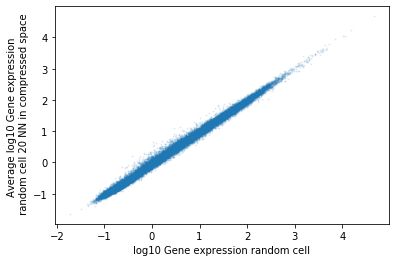

0.9958838199979628


In [273]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import spearmanr
import matplotlib
matplotlib.rcParams['svg.fonttype'] = 'none'
k=100
X = np.array(compressed.copy())
cells = np.array(cells)
ncells = len(cells)
n = random.sample(list(range(ncells)),2)
dist = euclidean_distances(X, X[n,:])
rank = dist.argpartition(k+1,axis=0)[:k+1,:]
idx = n[0]
i=0
cell = cells[idx]
knn = cells[rank[:,i]]
knn = knn[knn!=cell]
tsig = SCMatrix[cell]
tavg = np.average(SCMatrix[knn[1:]],axis=1)
plt.scatter(np.log10(tsig),np.log10(tavg),s=1,alpha=0.1)
plt.xlabel('log10 Gene expression random cell')
plt.ylabel('Average log10 Gene expression \n random cell 20 NN in compressed space')
plt.show()
print(spearmanr(tsig,tavg)[0])

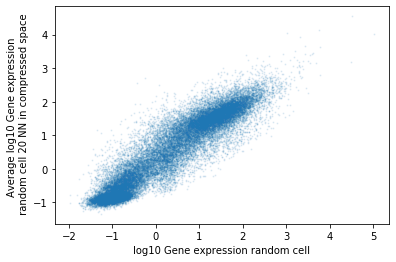

0.9258239872366417


In [272]:
tavg = np.average(SCMatrix,axis=1)
plt.scatter(np.log10(tsig),np.log10(tavg),s=1,alpha=0.1)
plt.xlabel('log10 Gene expression random cell')
plt.ylabel('Average log10 Gene expression \n random cell 20 NN in compressed space')
plt.show()
print(spearmanr(tsig,tavg)[0])

/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home/zach/miniconda3/envs/pytorch/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


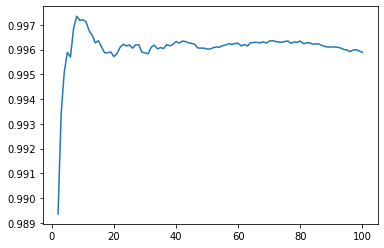

In [274]:
nn_count = []
correlation = []
for i in tqdm.tqdm(range(k)):
    tavg = np.average(SCMatrix[knn[1:1+i]],axis=1)
    nn_count.append(1+i)
    correlation.append(spearmanr(tsig,tavg)[0])
plt.plot(nn_count,correlation)
plt.show()

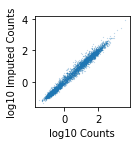

0.9870133841032886
0.9447355937239432


In [334]:
import matplotlib
import random
matplotlib.rcParams['svg.fonttype'] = 'none'
keepers = random.sample(list(SCMatrix.index),5000)
tsig = SCMatrix[cell].loc[keepers]
tavg = np.average(SCMatrix[knn[1:10]].loc[keepers],axis=1)
plt.figure(figsize=[2,2])
plt.scatter(np.log10(tsig),np.log10(tavg),s=0.01,alpha=1)
plt.xlabel('log10 Counts')
plt.ylabel('log10 Imputed Counts')
plt.tight_layout()
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/Imputation_counts.svg',format='svg')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/Imputation_counts.eps',format='eps')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/Imputation_counts.pdf')
plt.show()
print(spearmanr(tsig,tavg)[0])
from scipy.stats import pearsonr
print(pearsonr(tsig,tavg)[0])

In [283]:
tgene_variance = np.std(SCMatrix,axis=1)
tgene_median= np.median(SCMatrix,axis=1)
tsig_variance = (SCMatrix[cell]-tgene_median)/tgene_variance
tavg_variance = (np.average(SCMatrix[knn[1:10]],axis=1)-tgene_median)/tgene_variance

In [335]:
tavg_variance

Reps1     -0.060555
Soga3      0.012642
Rps15      0.826790
Anks1b     0.000863
Eea1       0.693355
             ...   
n-R5s71    0.861190
n-R5s72    1.177361
n-R5s85   -0.073242
n-R5s88    1.683992
n-R5s89    2.343219
Length: 32355, dtype: float64

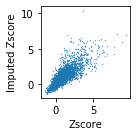

0.8470694566992056


In [336]:
matplotlib.rcParams['svg.fonttype'] = 'none'
plt.figure(figsize=[2,2])
keepers = random.sample(list(SCMatrix.index),5000)
plt.scatter(tsig_variance.loc[keepers],tavg_variance.loc[keepers],s=0.1,alpha=1)
# plt.colorbar()
plt.xlabel('Zscore')
plt.ylabel('Imputed Zscore')
plt.tight_layout()
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/Imputation_Zscore.svg',format='svg')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/Imputation_Zscore.eps',format='eps')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/Imputation_Zscore.pdf')
plt.show()
print(spearmanr(tsig_variance,tavg_variance)[0])

In [289]:
from scipy.stats import pearsonr
print(pearsonr(tsig_variance,tavg_variance)[0])

0.9543323488346565


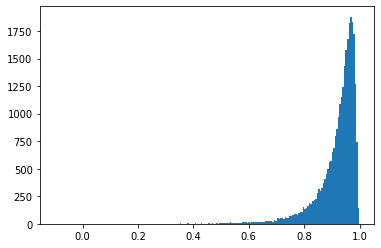

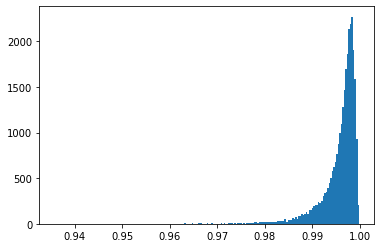

In [313]:
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import spearmanr
k=10
X = np.array(compressed.copy())
cells = np.array(cells)
ncells = len(cells)
# n = random.sample(list(range(ncells)),10000)
n = range(ncells)
dist = euclidean_distances(X, X[n,:])
rank = dist.argpartition(k+1,axis=0)[:k+1,:]
correlations_Zscore = []
correlations_counts = []
for i,idx in tqdm.tqdm(enumerate(n),total=len(n)):
    cell = cells[idx]
    knn = cells[rank[:,i]]
    knn = knn[knn!=cell]
    tsig = SCMatrix[cell]
    tavg = np.average(SCMatrix[knn[1:]],axis=1)
    tsig_variance = (tsig-tgene_median)/tgene_variance
    tavg_variance = (tavg-tgene_median)/tgene_variance
    correlations_Zscore.append(spearmanr(tsig_variance,tavg_variance)[0])
    correlations_counts.append(spearmanr(tsig,tavg)[0])
plt.hist(correlations_Zscore,bins=200)
plt.show()
plt.hist(correlations_counts,bins=200)
plt.show()

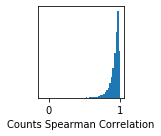

In [347]:
matplotlib.rcParams['svg.fonttype'] = 'none'
plt.figure(figsize=[2,2])
plt.hist(correlations_Zscore,bins=50)
plt.xlabel('Counts Spearman Correlation')
plt.yticks([])
plt.tight_layout()
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F1C_Zscore_hist.eps',format='eps')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F1C_Zscore_hist.svg',format='svg')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F1C_Zscore_hist.pdf')
plt.show()

In [349]:
np.median(correlations_Zscore)

0.9421223392138369

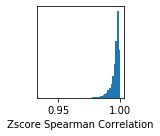

In [348]:
matplotlib.rcParams['svg.fonttype'] = 'none'
plt.figure(figsize=[2,2])
plt.hist(correlations_counts,bins=50)
plt.xlabel('Zscore Spearman Correlation')
plt.yticks([])
plt.tight_layout()
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F1C_counts_hist.eps',format='eps')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F1C_counts_hist.svg',format='svg')
plt.savefig('/bigstore/GeneralStorage/Zach/CSI/Grant_Figures/F1C_counts_hist.pdf')
plt.show()

In [350]:
np.median(correlations_counts)

0.9970352043098805

In [ ]:
matplotlib.rcParams['svg.fonttype'] = 'none'
plt.figure(figsize=[2,2])
plt.hist(correlations_counts,bins=50)
plt.xlabel('Zscore Spearman Correlation')
plt.yticks([])
plt.
plt.tight_layout()
plt.show()